### References

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.youtube.com/watch?v=yH1cF7GnoIo    

https://www.datacamp.com/community/tutorials/tensorflow-tutorial    



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Aux functions



In [2]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == classNames

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def show_data(s1,l1, s2,l2, labels, min):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 100, bottom = min)
    plt.legend(loc='upper left')
    plt.show()

def show_batch(image_batch, label_batch):
    columns = 6
    rows = BATCH_SIZE / columns + 1  
    plt.figure(figsize=(10, 2 * rows))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(int(rows), columns, n+1)
        plt.imshow((image_batch[n]))
        plt.title(classNames[label_batch[n]==1][0])
        plt.axis('off')


def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    


def show_accuracies(labels, test, val): 

    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.97)
    plt.legend(loc='upper left')
    plt.show()    



def show_misclassified(predictions, ground_truth, images, num_rows = 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    print(num_images)
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label, img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(8))
    plt.yticks([])
    thisplot = plt.bar(range(8), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.where(true_label)[0][0]].set_color('blue')   



def show_confusion_matrix(mat, classes):

    df_cm = pd.DataFrame(mat, range(classes), range(classes))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()    

In [3]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]
    

### Batch size

Batch size is an important parameter when training a network. It can influence speed and generalization, not necessarily in the same direction. There is no golden rule for the batch size but 32 is a commom number to start with.

In here we go to 64 to achieve faster training epochs (rather than 32)

See: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/



In [4]:
BATCH_SIZE = 128
IMAGE_SIZE = 32

### Prepare to load images

In [5]:
data_dir = pathlib.Path('./Final_Training/Images/')
  
classNames = np.array(os.listdir(data_dir))
classNames


array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007', '00008', '00009', '00010', '00011', '00012', '00013',
       '00014', '00015', '00016', '00017', '00018', '00019', '00020',
       '00021', '00022', '00023', '00024', '00025', '00026', '00027',
       '00028', '00029', '00030', '00031', '00032', '00033', '00034',
       '00035', '00036', '00037', '00038', '00039', '00040', '00041',
       '00042'], dtype='<U5')

### Loading images takes place in here

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files("./Final_Training/Images/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)



### Information about image shape and size of training set

In [7]:
t = next(iter(dataset))
print(t[0].shape, t[1].shape)

# note: this only works if dataset is not repeating
dataset_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", dataset_length)  

(32, 32, 3) (43,)
Total images in dataset:  39209


# Version I - training with dataset only

### Preparing training, validation and test datasets

In [8]:
dataSolo = dataset
dataSolo = dataSolo.cache()
dataSolo = dataSolo.shuffle(buffer_size = dataset_length)

In [9]:
perc = 20
size_train = int(len(dataSolo)* (100-perc)/100)
size_val = int(len(dataSolo))-size_train
train_listset_org = dataSolo.take(size_train)
train_listset = train_listset_org.prefetch(buffer_size=size_train)
train_listset = train_listset.batch(batch_size=BATCH_SIZE)
train_listset = train_listset.repeat()
val_listset = dataSolo.skip(size_train)
val_dataset_length = val_listset.cardinality().numpy()
print("Total images in validatation dataset: ", val_dataset_length)

valset = val_listset#.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
valset = valset.cache()
valset = valset.shuffle(buffer_size = size_val)
valset = valset.batch(batch_size = BATCH_SIZE)
valset = valset.prefetch(buffer_size = AUTOTUNE)


Total images in validatation dataset:  7842


In [10]:
test_listset = tf.data.Dataset.list_files("./Final_Test/Images/*/*.png")
test_dataset_length = test_listset.cardinality().numpy()
print("Total images in validatation dataset: ", test_dataset_length)

testset = test_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size = BATCH_SIZE)


Total images in validatation dataset:  12630


### Show a batch of training images

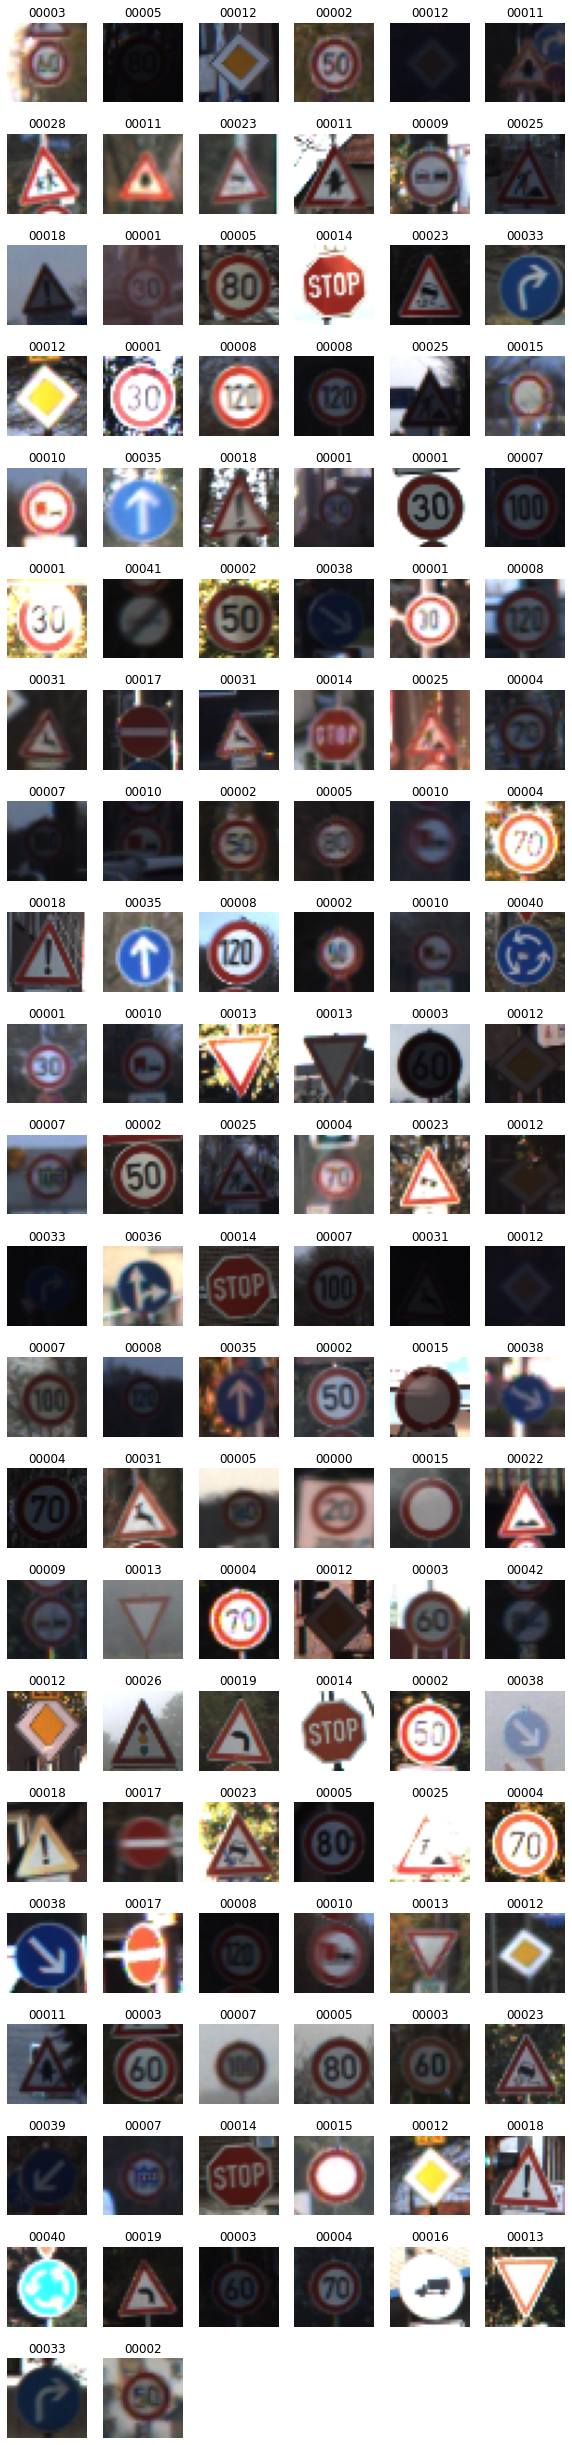

In [11]:
image_batch, label_batch = next(iter(train_listset))        
show_batch(image_batch, label_batch.numpy())

### Build a CNN network

In [12]:
def model_VI(classCount, imgSize, channels):

    model = Sequential()
    
    model.add(Conv2D(128, (5, 5),
                     input_shape=(imgSize, imgSize, channels)))         
    model.add(LeakyReLU(alpha=0.01))  
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 

    model.add(Conv2D(196, (5, 5) )) 
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 

    model.add(Conv2D(256, (5, 5) ) )   
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 
    
    model.add(Flatten())
    model.add(LeakyReLU(alpha=0.0)) 
    model.add(Dense(384))
    model.add(LeakyReLU(alpha=0.0))             
    model.add(Dropout(0.5)) 
    
    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model


In [13]:
modelV1 = model_VI(43, 32, 3)

print(modelV1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       9728      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 128)       512       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 196)       627396    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 196)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 196)       0

### Train the network 

In [14]:
file_pathV1 = './model/cp.ckpt'

callbacksV1 = prepare_callbacks(file_pathV1)

historyV1 = modelV1.fit(train_listset, steps_per_epoch = size_train/BATCH_SIZE,
          epochs=50, 
          validation_data = valset, 
          callbacks = callbacksV1)

Epoch 1/50
245/245 [==============================] - 41s 117ms/step - loss: 2.9320 - accuracy: 0.2557 - val_loss: 3.2836 - val_accuracy: 0.2253

Epoch 00001: val_accuracy improved from -inf to 0.22533, saving model to ./model\cp.ckpt
Epoch 2/50
245/245 [==============================] - 28s 115ms/step - loss: 1.3638 - accuracy: 0.5992 - val_loss: 1.5864 - val_accuracy: 0.5411

Epoch 00002: val_accuracy improved from 0.22533 to 0.54106, saving model to ./model\cp.ckpt
Epoch 3/50
245/245 [==============================] - 28s 115ms/step - loss: 0.7029 - accuracy: 0.7824 - val_loss: 0.2544 - val_accuracy: 0.9304

Epoch 00003: val_accuracy improved from 0.54106 to 0.93037, saving model to ./model\cp.ckpt
Epoch 4/50
245/245 [==============================] - 28s 115ms/step - loss: 0.4108 - accuracy: 0.8740 - val_loss: 0.1010 - val_accuracy: 0.9753

Epoch 00004: val_accuracy improved from 0.93037 to 0.97526, saving model to ./model\cp.ckpt
Epoch 5/50
245/245 [==============================]

### Plot the training history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


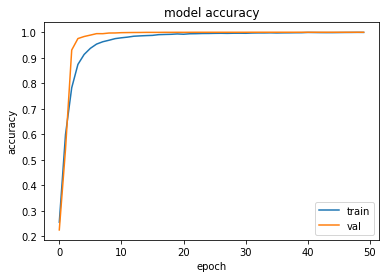

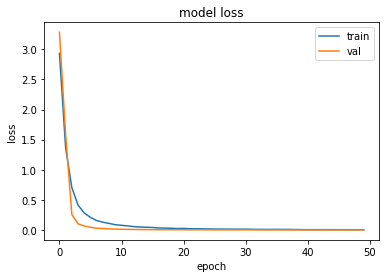

In [15]:
show_history(historyV1)

### Evaluate Model

In [16]:
modelV1.load_weights(file_pathV1)

evalV1 = modelV1.evaluate(testset, verbose=2)
valV1 = modelV1.evaluate(valset, verbose=2)

99/99 - 28s - loss: 0.0725 - accuracy: 0.9819
62/62 - 2s - loss: 4.6830e-04 - accuracy: 1.0000


# Version II - dynamic data augmentation

### Function to transform image

In [71]:


#https://www.tensorflow.org/api_docs/python/tf/image
#https://www.tensorflow.org/addons/api_docs/python/tfa/image

#pip install tensorflow-addons
import tensorflow_addons as tfa


def process_image(image, label):
    
    # random rotate 5 degrees
    r = tf.random.uniform(shape=(), minval=-0.175, maxval=0.175, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, r)

    # translate image up to 10%
    rx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    ry = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    image = tfa.image.translate(image, [rx, ry])
   
    # change hue, saturation and value
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.2, 0.4, 1.1, 0.4, 1.1),0,1)

    return image, label

In [72]:
dataV2 = train_listset_org
dataV2 = dataV2.cache()
dataV2 = dataV2.shuffle(buffer_size = dataset_length)
dataV2 = dataV2.map(process_image)
dataV2 = dataV2.prefetch(buffer_size=size_train)
dataV2 = dataV2.batch(batch_size=BATCH_SIZE)
dataV2 = dataV2.repeat()

In [ ]:
modelV2 = model_VI(43, 32, 3)

file_pathV2 = 'd:\\temp\\best_modelV2\\cp.ckpt'

callbacksV2 = prepare_callbacks(file_pathV2)

historyV2 = modelV2.fit(dataV2, steps_per_epoch = size_train/BATCH_SIZE,
          epochs=50, 
          validation_data = valset, 
          callbacks = callbacksV2)

Epoch 1/50
245/245 [==============================] - 31s 122ms/step - loss: 3.5053 - accuracy: 0.1274 - val_loss: 3.3650 - val_accuracy: 0.1285

Epoch 00001: val_accuracy improved from -inf to 0.12854, saving model to d:\temp\best_modelV2\cp.ckpt
Epoch 2/50
245/245 [==============================] - 30s 121ms/step - loss: 2.6825 - accuracy: 0.2766 - val_loss: 2.1777 - val_accuracy: 0.4315

Epoch 00002: val_accuracy improved from 0.12854 to 0.43152, saving model to d:\temp\best_modelV2\cp.ckpt
Epoch 3/50
245/245 [==============================] - 30s 121ms/step - loss: 2.0356 - accuracy: 0.4176 - val_loss: 0.9436 - val_accuracy: 0.7116

Epoch 00003: val_accuracy improved from 0.43152 to 0.71155, saving model to d:\temp\best_modelV2\cp.ckpt
Epoch 4/50
 10/245 [>.............................] - ETA: 26s - loss: 1.7737 - accuracy: 0.4703

In [ ]:
show_history(historyV2)

modelV2.load_weights(file_pathV2)

evalV2 = modelV2.evaluate(testset, verbose=2)
valV2 = modelV2.evaluate(valset, verbose=2)

# Version III - Massive data augmentation

### Data augmentation functions

In [ ]:
import tensorflow_addons as tfa

def process_brightness(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)
    return img, label

def process_saturation(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):
    
    img = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)
    return img, label

def process_hue(image, label):
    
    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_shear(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):
    
    c = tf.random.uniform(shape=(), minval=24, maxval=32, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[c,c,3])
    img = tf.image.resize(img ,size= [32,32])
    return img, label

In [ ]:
dataV3 = dataset
# color ops
dataV3 = dataV3.map(process_brightness)
dataV3 = dataV3.concatenate(dataset.map(process_contrast))
dataV3 = dataV3.concatenate(dataset.map(process_hue))
dataV3 = dataV3.concatenate(dataset.map(process_saturation))

#geometry ops
dataV3 = dataV3.concatenate(dataset.map(process_rotate))
dataV3 = dataV3.concatenate(dataset.map(process_shear))
dataV3 = dataV3.concatenate(dataset.map(process_translate))
dataV3 = dataV3.concatenate(dataset.map(process_crop))

dataV3 = dataV3.cache()
dataV3 = dataV3.shuffle(buffer_size = 81600)
dataV3 = dataV3.batch(batch_size = BATCH_SIZE)
dataV3 = dataV3.prefetch(buffer_size = AUTOTUNE)
dataV3 = dataV3.repeat()



In [ ]:
modelV3 = model_VI(8, 32, 3)

file_pathV3 = 'd:\\temp\\best_modelV3\\cp.ckpt'

callbacksV3 = prepare_callbacks(file_pathV3)

historyV3 = modelV3.fit(dataV3, steps_per_epoch = 81600/BATCH_SIZE,
          epochs=50, 
          validation_data = valset, 
          callbacks = callbacksV3)

In [ ]:
show_history(historyV3)

modelV3.load_weights(file_pathV3)

evalV3 = modelV3.evaluate(testset, verbose=2)
valV3 = modelV3.evaluate(valset, verbose=2)

In [ ]:


show_accuracies(['V1', 'V2', 'V3'], [evalV1[1], evalV2[1], evalV3[1]], [valV1[1], valV2[1], valV3[1]])

In [ ]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in testset.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(modelV3.predict(images.numpy()))


show_misclassified(pred, numpy_labels, numpy_images, int((4170 - 4170*.994)/3 + 1))

In [ ]:
all_labels = [np.argmax(x) for x in numpy_labels]
all_preds = [np.argmax(x) for x in pred]
    
conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

show_confusion_matrix(conf_mat.numpy(), 8)

